**Nina Dobša, zadnje mijenjano 28.7.2025.**

> Dodaj oznaku dugog citata



# Imports

In [ ]:
%pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
^C


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForMaskedLM, BertForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Connecting with google drive where fine tuned models are stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Uploading ISEAR data
file_path = "/content/drive/My Drive/data/isear_3.txt"
ISEAR_data = pd.read_csv(file_path, delimiter="|", header=0, on_bad_lines="skip", engine="python")

# Select only Emotion and Text columns from original dataset
ISEAR_data = ISEAR_data[['SIT', 'Field1']]
ISEAR_data.columns = ['text', 'emotion']
ISEAR_data.shape

(7505, 2)

In [ ]:
# Encoding emotions (from words to numbers)
label_encoder = LabelEncoder()
ISEAR_data['emotion_label'] = label_encoder.fit_transform(ISEAR_data['emotion'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}


In [ ]:
# Defining number of classes and length of the sequence (if the sentence is shorter padding will be added)
num_classes = 7
max_sequence_length = 30

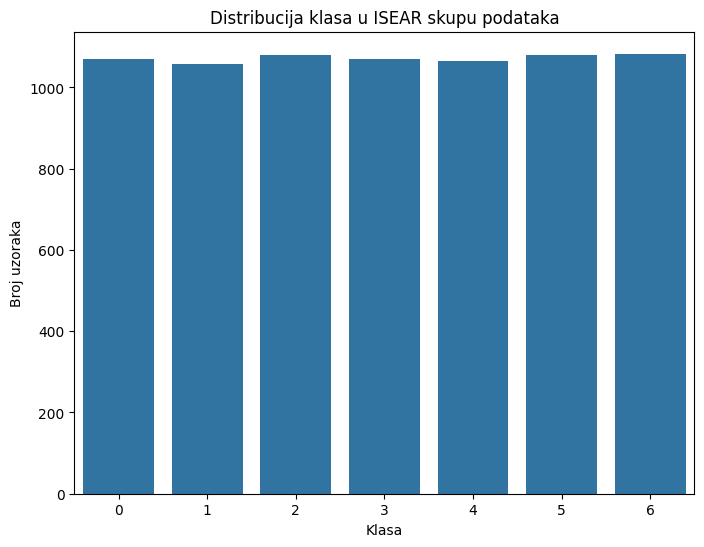

In [ ]:
# Visualization of class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='emotion_label', data=ISEAR_data)
plt.title('Distribucija klasa u ISEAR skupu podataka')
plt.xlabel('Klasa')
plt.ylabel('Broj uzoraka')
plt.show()

Classes are balanced...

# Word2Vec Embeddings

In [ ]:
# Import of fine tuned word2vec model
model_path_SG = "/content/drive/My Drive/modeli/SG_15/SG_15.model"
model_path_CBOW = "/content/drive/My Drive/modeli/CBOW_10/CBOW_10.model"
word2vec_model_SG = Word2Vec.load(model_path_SG)
word2vec_model_CBOW = Word2Vec.load(model_path_CBOW)

embedding_dim_SG = word2vec_model_SG.vector_size
embedding_dim_CBOW = word2vec_model_CBOW.vector_size

In [ ]:
# Function for getting word2vec embeddings
def get_word2vec_embeddings(sentence, model):
    # Tokenization
    sentence = sentence.lower()
    words = sentence.split()
    word_embeddings = [model.wv[word] for word in words if word in model.wv]

    if not word_embeddings:  # If no words are in the vocabulary, return a zero vector
        return []

    return word_embeddings

In [ ]:
# Getting word2vec embeddings for each word in the sentence
list_of_embeddings_CBOW = [
   get_word2vec_embeddings(text, word2vec_model_CBOW)
    for text in ISEAR_data['text']
]

list_of_embeddings_SG = [
   get_word2vec_embeddings(text, word2vec_model_SG)
    for text in ISEAR_data['text']
]

In [ ]:
# Padding sequences to the same length -> adding zeroes to the sequences shorter than embedding_dim and cutting sequences longer than embedding_dim
# Converting to NumPy array
embeddings_CBOW = pad_sequences(
    list_of_embeddings_CBOW,
    maxlen = max_sequence_length,
    dtype = 'float32',
    padding = 'post',
    truncating = 'post'
)

# print(embeddings_CBOW)

In [ ]:
# Padding sequences to the same length -> adding zeroes to the sequences shorter than embedding_dim and cutting sequences longer than embedding_dim
# Converting to NumPy array
embeddings_SG = pad_sequences(
    list_of_embeddings_SG,
    maxlen = max_sequence_length,
    dtype = 'float32',
    padding = 'post',
    truncating = 'post'
)

# print(embeddings_SG)

In [ ]:
# One-hot encoding of target values
y = to_categorical(ISEAR_data['emotion_label'], num_classes=num_classes)
y_original_labels = ISEAR_data['emotion_label'].values

print(f"Dimensions of embeddings_CBOW: {embeddings_CBOW.shape}") # (number_of_examples, sequence_length, embedding_dim)
print(f"Dimensions of embeddings_SG: {embeddings_SG.shape}") # (number_of_examples, sequence_length, embedding_dim)
print(f"Dimensions of target value: {y.shape}") # (number_of_examples, num_classes)

Dimensions of embeddings_CBOW: (7505, 30, 300)
Dimensions of embeddings_SG: (7505, 30, 300)
Dimensions of target value: (7505, 7)


# RNN predictions for Word2Vec embeddings

### Predictions for SG embeddings

In [ ]:
# Model parameters
n_splits = 5 # 5-fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
lstm_units = 128
dropout_rate = 0.3

fold_accuracies = []
fold_losses = []
fold_f1_macros = []
fold_auc_macros = []
fold_precision_macros = []
fold_recall_macros = []
fold_confusion_matrices = []

for fold, (train_index, val_index) in enumerate(skf.split(embeddings_SG, y_original_labels)):
    print(f"\n--- Training Fold {fold + 1}/{n_splits} ---")

    X_train_fold, X_val_fold = embeddings_SG[train_index], embeddings_SG[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    clear_session()  # Reseting Keras session to build new model

    # Build LSTM Bidirectional model
    model = Sequential()
    model.add(Input(shape=(max_sequence_length, embedding_dim_SG)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    # Training
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_callback],
        verbose=0
    )

    # Evaluation
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    y_pred_probs_fold = model.predict(X_val_fold, verbose=0)
    y_pred_classes_fold = np.argmax(y_pred_probs_fold, axis=1)
    y_true_classes_fold = np.argmax(y_val_fold, axis=1)

    precision_macro_fold = precision_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    recall_macro_fold = recall_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    f1_macro_fold = f1_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)

    fold_precision_macros.append(precision_macro_fold)
    fold_recall_macros.append(recall_macro_fold)
    fold_f1_macros.append(f1_macro_fold)

    try:
        auc_macro_fold = roc_auc_score(y_true_classes_fold, y_pred_probs_fold, multi_class='ovr', average='macro')
        fold_auc_macros.append(auc_macro_fold)
    except ValueError:
        fold_auc_macros.append(np.nan)

    # --- Confusion matrix ---
    cm = confusion_matrix(y_true_classes_fold, y_pred_classes_fold)
    fold_confusion_matrices.append(cm)

    print(f"   Fold {fold + 1} - Val Loss: {loss:.4f}, Val Acc: {accuracy:.4f}, "
          f"Val Precision-macro: {precision_macro_fold:.4f}, Val Recall-macro: {recall_macro_fold:.4f}, "
          f"Val F1-macro: {f1_macro_fold:.4f}, Val AUC-macro: {fold_auc_macros[-1]:.4f}")
    print(f"   Confusion Matrix:\n{cm}")


--- Training Fold 1/5 ---
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
   Fold 1 - Val Loss: 1.3983, Val Acc: 0.5396, Val Precision-macro: 0.5411, Val Recall-macro: 0.5398, Val F1-macro: 0.5381, Val AUC-macro: 0.8521
   Confusion Matrix:
[[ 85  38   5  27  10  29  20]
 [ 16 118   9  15  13  19  22]
 [ 13  18 128  12   6  25  14]
 [ 18  20   9  97  15  19  36]
 [  7   8   6   4 159  21   8]
 [ 17  11  11  17  22 128  10]
 [ 26  21  10  40  13  11  95]]

--- Training Fold 2/5 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
   Fold 2 - Val Loss: 1.3057, Val Acc: 0.5430, Val Precision-macro: 0.5520, Val Recall-macro: 0.5431, Val F1-macro: 0.5396, Val AUC-macro: 0.8515
   Confusion Matrix:
[[126  16   6  22  11  19  14]
 [ 50 105  19   6  12   9  11]
 [ 23  12 137  12  10  17   5]
 [ 55   9  16  90   7  15  22]
 [ 14   8   7   9 156  19   0]
 [ 20   6  11  17  23 131   8]
 [ 35  20  20  39  23   9  70]]

--- Tra

In [ ]:
# Calculation of average results across all folds +/ std.dev
print("\n--- Average cross validation results for Word2Vec SG embeddings ---")
print(f"Loss: {np.mean(fold_losses):.4f} +/- {np.std(fold_losses):.4f}")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Precision-macro: {np.mean(fold_precision_macros):.4f} +/- {np.std(fold_precision_macros):.4f}")
print(f"Recall-macro: {np.mean(fold_recall_macros):.4f} +/- {np.std(fold_recall_macros):.4f}")
print(f"F1-macro: {np.mean(fold_f1_macros):.4f} +/- {np.std(fold_f1_macros):.4f}")
print(f"AUC-macro: {np.nanmean(fold_auc_macros):.4f} +/- {np.nanstd(fold_auc_macros):.4f}")
avg_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
print(f"Average Confusion Matrix across folds:\n{avg_confusion_matrix.astype(int)}")


--- Average cross validation results for Word2Vec SG embeddings ---
Loss: 1.3237 +/- 0.0433
Accuracy: 0.5450 +/- 0.0053
Precision-macro: 0.5538 +/- 0.0089
Recall-macro: 0.5452 +/- 0.0055
F1-macro: 0.5428 +/- 0.0045
AUC-macro: 0.8534 +/- 0.0024
Average Confusion Matrix across folds:
[[102  23  10  30  13  18  14]
 [ 31 115  13  12  11  12  15]
 [ 14  14 141  12   9  16   7]
 [ 37  10  12 100  10  18  25]
 [ 10   7   7   8 153  18   7]
 [ 19   8  12  18  21 126  10]
 [ 29  20  16  47  15  10  77]]


### Predictions for CBOW embeddings

In [ ]:
# Model parameters
n_splits = 5 # 5-fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
lstm_units = 128
dropout_rate = 0.3

fold_accuracies = []
fold_losses = []
fold_f1_macros = []
fold_auc_macros = []
fold_precision_macros = []
fold_recall_macros = []
fold_confusion_matrices = []

for fold, (train_index, val_index) in enumerate(skf.split(embeddings_CBOW, y_original_labels)):
    print(f"\n--- Training Fold {fold + 1}/{n_splits} ---")

    X_train_fold, X_val_fold = embeddings_CBOW[train_index], embeddings_CBOW[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    clear_session() # Reseting Keras session to build new model

    # Building an LSTM Bidirectional model
    model = Sequential()
    model.add(Input(shape=(max_sequence_length, embedding_dim_CBOW)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping Callback - to prevent model of overfitting
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy', # We are tracking validation accuracy
        patience=5,             # The training stops if the val_accuracy doesn't get better after 5 epochs
        restore_best_weights=True,
        mode='max',             # Maximizing accuracy
        verbose=1
    )

    # Training the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,   # trining in 50 epochs (we assume early stopping call back will end the training before)
        batch_size=batch_size,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_callback],
        verbose=0
    )

    # Evaluating the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    y_pred_probs_fold = model.predict(X_val_fold, verbose=0)
    y_pred_classes_fold = np.argmax(y_pred_probs_fold, axis=1)
    y_true_classes_fold = np.argmax(y_val_fold, axis=1)

    precision_macro_fold = precision_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    recall_macro_fold = recall_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)

    fold_precision_macros.append(precision_macro_fold)
    fold_recall_macros.append(recall_macro_fold)

    f1_macro_fold = f1_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    fold_f1_macros.append(f1_macro_fold)

    try:
        auc_macro_fold = roc_auc_score(y_true_classes_fold, y_pred_probs_fold, multi_class='ovr', average='macro')
        fold_auc_macros.append(auc_macro_fold)
    except ValueError as e:
        fold_auc_macros.append(np.nan)

    # --- Confusion matrix ---
    cm = confusion_matrix(y_true_classes_fold, y_pred_classes_fold)
    fold_confusion_matrices.append(cm)

    print(f"   Fold {fold + 1} - Val Loss: {loss:.4f}, Val Acc: {accuracy:.4f}, "
          f"Val Precision-macro: {precision_macro_fold:.4f}, Val Recall-macro: {recall_macro_fold:.4f}, "
          f"Val F1-macro: {f1_macro_fold:.4f}, Val AUC-macro: {fold_auc_macros[-1]:.4f}")
    print(f"   Confusion Matrix:\n{cm}")


--- Training Fold 1/5 ---
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.
   Fold 1 - Val Loss: 1.4503, Val Acc: 0.5157, Val Precision-macro: 0.5192, Val Recall-macro: 0.5158, Val F1-macro: 0.5020, Val AUC-macro: 0.8364
   Confusion Matrix:
[[ 97  22  14  15  27  30   9]
 [ 31  97  29   7  21  20   7]
 [  9   7 143   8  17  27   5]
 [ 32  14  26  85  19  28  10]
 [  7   2  12   6 167  17   2]
 [ 20  14  14   5  25 133   5]
 [ 38  25  21  45  18  17  52]]

--- Training Fold 2/5 ---
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.
   Fold 2 - Val Loss: 1.3549, Val Acc: 0.5150, Val Precision-macro: 0.5361, Val Recall-macro: 0.5148, Val F1-macro: 0.5138, Val AUC-macro: 0.8392
   Confusion Matrix:
[[119  14  12  29   6  20  14]
 [ 60  78  24  13   7  10  20]
 [ 20   8 144  18   6  17   3]
 [ 46   3  13 107   8  14  23]
 [ 18   9   7  15 129  28   7]
 [ 21   4  11  27  14 130   9]
 [ 37   6  22  58  16  11  66]]

--- T

In [ ]:
# Calculation of average results across all folds +/ std.dev
print("\n--- Average cross validation results for Word2Vec CBOW embeddings ---")
print(f"Val Loss: {np.mean(fold_losses):.4f} +/- {np.std(fold_losses):.4f}")
print(f"Val Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Val Precision-macro: {np.mean(fold_precision_macros):.4f} +/- {np.std(fold_precision_macros):.4f}")
print(f"Val Recall-macro: {np.mean(fold_recall_macros):.4f} +/- {np.std(fold_recall_macros):.4f}")
print(f"Val F1-macro: {np.mean(fold_f1_macros):.4f} +/- {np.std(fold_f1_macros):.4f}")
print(f"Val AUC-macro: {np.nanmean(fold_auc_macros):.4f} +/- {np.nanstd(fold_auc_macros):.4f}")
avg_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
print(f"Average Confusion Matrix across folds:\n{avg_confusion_matrix.astype(int)}")


--- Average cross validation results for Word2Vec CBOW embeddings ---
Val Loss: 1.4150 +/- 0.0561
Val Accuracy: 0.5073 +/- 0.0097
Val Precision-macro: 0.5154 +/- 0.0134
Val Recall-macro: 0.5074 +/- 0.0098
Val F1-macro: 0.5017 +/- 0.0081
Val AUC-macro: 0.8331 +/- 0.0048
Average Confusion Matrix across folds:
[[104  19  12  25  18  18  14]
 [ 39  93  22  10  17  13  15]
 [ 15   7 138  12  15  18   8]
 [ 41   8  16  86  13  21  27]
 [ 13   5   9   8 150  18   7]
 [ 22   9  13  17  24 119  10]
 [ 35  16  19  46  17  13  68]]


# BERT Embeddings

In [ ]:
# Import of fine tuned bert model
#model_path = "/content/drive/My Drive/modeli/BERT_5"
model_path = "/content/drive/My Drive/fine_tuned_bert"
bert_model = BertForMaskedLM.from_pretrained(model_path)
bert_tokenizer = BertTokenizer.from_pretrained(model_path)
embedding_dim_bert = bert_model.config.hidden_size

In [ ]:
# Function for getting bert embeddings
def get_bert_embeddings(sentence, bert_model, bert_tokenizer, max_sequence_length_for_lstm):

    padding_zeroes = np.zeros(embedding_dim_bert, dtype=np.float32) # used to pad sequences shorter than sequence_length (50)

    inputs = bert_tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert_model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs.get('attention_mask', None),
            token_type_ids=inputs.get('token_type_ids', None),
            output_hidden_states=True
        )

    # Last hidden state: (seq_len, embedding_dim)
    token_embeddings = outputs.hidden_states[-1].squeeze(0).cpu().numpy()
    input_ids = inputs['input_ids'].squeeze(0).cpu().numpy()

    # Filter out special tokens
    filtered_embeddings = []
    for i, token_id in enumerate(input_ids):
        token_str = bert_tokenizer.decode([token_id])
        if token_str in bert_tokenizer.all_special_tokens or not token_str.strip():
            continue
        filtered_embeddings.append(token_embeddings[i])

    return np.array(filtered_embeddings, dtype=np.float32)  # shape: (seq_len, embedding_dim)

In [ ]:
# Getting bert embeddings for each word in the sentence
list_of_embeddings_BERT = [
   get_bert_embeddings(text, bert_model, bert_tokenizer, max_sequence_length)
    for text in ISEAR_data['text']
]

In [ ]:
# Padding sequences to the same length -> adding zeroes to the sequences shorter than embedding_dim and cutting sequences longer than embedding_dim
# Converting to NumPy array
embeddings_BERT = pad_sequences(
    list_of_embeddings_BERT,
    maxlen = max_sequence_length,
    dtype = 'float32',
    padding = 'post',
    truncating = 'post'
)

# print (embeddings_BERT)

In [ ]:
# One-hot encoding of target values
y = to_categorical(ISEAR_data['emotion_label'], num_classes=num_classes)

print(f"\nDimensions of embeddings_BERT: {embeddings_BERT.shape}") # (number_of_examples, sequence_length, embedding_dim)
print(f"Dimensions of target value: {y.shape}") # (number_of_examples, num_classes)


Dimensions of embeddings_BERT: (7505, 30, 768)
Dimensions of target value: (7505, 7)


# RNN predictions for BERT Embeddings

In [ ]:
# Model parameters
n_splits = 5 # 5-fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
lstm_units = 128
dropout_rate = 0.3

fold_accuracies = []
fold_losses = []
fold_f1_macros = []
fold_auc_macros = []
fold_precision_macros = []
fold_recall_macros = []
fold_confusion_matrices = []

for fold, (train_index, val_index) in enumerate(skf.split(embeddings_BERT, y_original_labels)):
    print(f"\n--- Training Fold {fold + 1}/{n_splits} ---")

    X_train_fold, X_val_fold = embeddings_BERT[train_index], embeddings_BERT[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    clear_session() # Reseting Keras session to build new model

    # Building an LSTM Bidirectional model
    model = Sequential()
    model.add(Input(shape=(max_sequence_length, embedding_dim_bert)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping Callback - to prevent model of overfitting
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy', # We are tracking validation accuracy
        patience=5,             # The training stops if the val_accuracy doesn't get better after 5 epochs
        restore_best_weights=True,
        mode='max',             # Maximizing accuracy
        verbose=1
    )

    # Training the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,   # trining in 50 epochs (we assume early stopping call back will end the training before)
        batch_size=batch_size,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_callback],
        verbose=0
    )

    # Evaluating the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    y_pred_probs_fold = model.predict(X_val_fold, verbose=0)
    y_pred_classes_fold = np.argmax(y_pred_probs_fold, axis=1)
    y_true_classes_fold = np.argmax(y_val_fold, axis=1)

    precision_macro_fold = precision_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    recall_macro_fold = recall_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)

    fold_precision_macros.append(precision_macro_fold)
    fold_recall_macros.append(recall_macro_fold)

    f1_macro_fold = f1_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    fold_f1_macros.append(f1_macro_fold)

    try:
        auc_macro_fold = roc_auc_score(y_true_classes_fold, y_pred_probs_fold, multi_class='ovr', average='macro')
        fold_auc_macros.append(auc_macro_fold)
    except ValueError as e:
        fold_auc_macros.append(np.nan)

   # --- Confusion matrix ---
    cm = confusion_matrix(y_true_classes_fold, y_pred_classes_fold)
    fold_confusion_matrices.append(cm)

    print(f"   Fold {fold + 1} - Val Loss: {loss:.4f}, Val Acc: {accuracy:.4f}")


--- Training Fold 1/5 ---
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.
   Fold 1 - Val Loss: 1.8591, Val Acc: 0.6342

--- Training Fold 2/5 ---
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
   Fold 2 - Val Loss: 1.4480, Val Acc: 0.6149

--- Training Fold 3/5 ---
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
   Fold 3 - Val Loss: 1.0871, Val Acc: 0.6422

--- Training Fold 4/5 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
   Fold 4 - Val Loss: 1.0908, Val Acc: 0.6382

--- Training Fold 5/5 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
   Fold 5 - Val Loss: 1.1295, Val Acc: 0.6342


In [ ]:
# Calculation of average results across all folds +/ std.dev
print("\n--- Average cross validation results for BERT embeddings ---")
print(f"Val Loss: {np.mean(fold_losses):.4f} +/- {np.std(fold_losses):.4f}")
print(f"Val Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Val Precision-macro: {np.mean(fold_precision_macros):.4f} +/- {np.std(fold_precision_macros):.4f}")
print(f"Val Recall-macro: {np.mean(fold_recall_macros):.4f} +/- {np.std(fold_recall_macros):.4f}")
print(f"Val F1-macro: {np.mean(fold_f1_macros):.4f} +/- {np.std(fold_f1_macros):.4f}")
print(f"Val AUC-macro: {np.nanmean(fold_auc_macros):.4f} +/- {np.nanstd(fold_auc_macros):.4f}")
avg_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
print(f"Average Confusion Matrix across folds:\n{avg_confusion_matrix.astype(int)}")


--- Average cross validation results for BERT embeddings ---
Val Loss: 1.3229 +/- 0.3000
Val Accuracy: 0.6328 +/- 0.0094
Val Precision-macro: 0.6426 +/- 0.0148
Val Recall-macro: 0.6329 +/- 0.0094
Val F1-macro: 0.6321 +/- 0.0088
Val AUC-macro: 0.8984 +/- 0.0052
Average Confusion Matrix across folds:
[[118  26  10  19   6  11  21]
 [ 32 129  11   9   4   7  17]
 [ 11   9 156   8   5  11  14]
 [ 25   8  11 108   3  14  43]
 [  4   2   4   3 180   9   8]
 [ 16  11  12  10  11 140  13]
 [ 21  14  12  38   7   6 116]]
